In [5]:
import spacy
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner"])

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
EPS = 1e-6

In [8]:
fun_fact_df = pd.read_csv('data/til_title.csv')

/Users/Arshi/anaconda/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,5,8,9,13,14,15,16,19,21,22,24,27,28,33,34,35,41,46,58,60,62,63,64,65,68,74,79,85,92,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
required_columns = ['title', 'subreddit', 'permalink']
fun_fact_df = fun_fact_df.dropna(axis='rows', subset=required_columns)

In [10]:
banned_subreddits = ['circlejerk', 'ShittyTodayILearned', 'TheOnion']
fun_fact_df = fun_fact_df[~fun_fact_df['subreddit'].isin(banned_subreddits)]

In [11]:
fun_fact_df = fun_fact_df.reset_index(drop=True)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

In [13]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=.8, ngram_range=(1,1), dtype=np.float32)
titles = fun_fact_df['title']
fun_fact_tfidf = vectorizer.fit_transform(titles)

In [14]:
fun_fact_tfidf

<309065x125402 sparse matrix of type '<class 'numpy.float32'>'
	with 2793174 stored elements in Compressed Sparse Row format>

In [15]:
len(vectorizer.get_feature_names())

125402

In [16]:
len(fun_fact_df['title'])

309065

In [17]:
np.sum(fun_fact_tfidf > 0, axis=1) # shows number of tfidf words per doc

matrix([[ 6],
        [10],
        [26],
        ...,
        [ 4],
        [14],
        [ 5]])

In [18]:
features = vectorizer.get_feature_names()
f_vectors = np.array([nlp.vocab[f].vector for f in features])
weighted_embedding = fun_fact_tfidf.dot(f_vectors)
print(weighted_embedding.shape)

(309065, 300)


In [19]:
n_weighted_embedding = weighted_embedding / (np.linalg.norm(weighted_embedding, axis=1)[:, np.newaxis] + EPS)

In [20]:
print(np.linalg.norm(n_weighted_embedding[22291]))
print(np.linalg.norm(n_weighted_embedding[10493]))

0.9999999
0.9999998


In [306]:
query = "famous trials news"
query_tfidf = vectorizer.transform([query])
query_weighted = query_tfidf.dot(f_vectors).flatten()
n_query_weighted = query_weighted / np.linalg.norm(query_weighted)
rankings = n_weighted_embedding.dot(n_query_weighted)
rankings_index = np.argsort(-rankings)
fun_fact_df[["subreddit", "title"]].loc[rankings_index]

,subreddit,title
61896,todayilearned,TIL industry drug trials are 4 times more likely to give a positive result than independently sponsored trials
100837,todayilearned,"TIL King Colomon of Hungary famously stated that ""As for the matter of witches, there is no such thing, therefore no further investigations or trials are to be held"" nearly 700 years before the Salem Witch Trials"
228312,todayilearned,"TIL that NEWS stands for ""notable events, weather, and sports"
153979,todayilearned,TIL A study has found that people who watch no news at all can answer questions about current events better than people who solely watch Fox News
94818,Showerthoughts,Today's /r/news are the next decades /r/TIL
192978,todayilearned,"TIL a man set himself on fire on USA for first time in history and not a single main newspaper considered ""news"""
202293,todayilearned,"TIL that during the Second World War, Nazi Germany performed very extensive medical experiments including extensive tests on children.... A lot of the experiments actually were used in developing modern medical techniques and many doctors got immunity for revealing their study results."
108128,todayilearned,"TIL - McMartin Preschool Trial; one of the longest and most expensive criminal trials in history. It included allegations of witchcraft, sexual abuse, flying teachers and hidden tunnels. None of which turned out to be true."
128696,todayilearned,TIL there is man whose full-time hobby is giving man-on-the-street interviews so he'll be quoted in major publications. He’s so successful that the AP has banned their reporters from talking to him for stories.
23229,todayilearned,"TIL the FBI recently came forward to admit that their forensic examiners gave flawed testimony on hair sample testing for at least 257 trials over 20 years. (Another 2,200 cases are being reviewed and 32 were death penalty trials)"


In [307]:
query_tfidf.data

array([0.69792724, 0.5233627 , 0.48886514], dtype=float32)

In [308]:
for i in range(20):
    print(rankings[rankings_index[i]], titles[rankings_index[i]])

0.7615336 TIL industry drug trials are 4 times more likely to give a positive result than independently sponsored trials
0.7465783 TIL King Colomon of Hungary famously stated that "As for the matter of witches, there is no such thing, therefore no further investigations or trials are to be held" nearly 700 years before the Salem Witch Trials
0.72198457 TIL that NEWS stands for "notable events, weather, and sports
0.71804994 TIL A study has found that people who watch no news at all can answer questions about current events better than people who solely watch Fox News
0.7104738 Today's /r/news are the next decades /r/TIL
0.7055966 TIL a man set himself on fire on USA for first time in history and not a single main newspaper considered "news"
0.70351666 TIL that during the Second World War, Nazi Germany performed very extensive medical experiments including extensive tests on children.... A lot of the experiments actually were used in developing modern medical techniques and many doctors

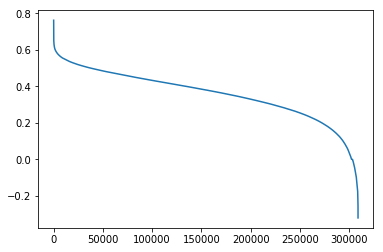

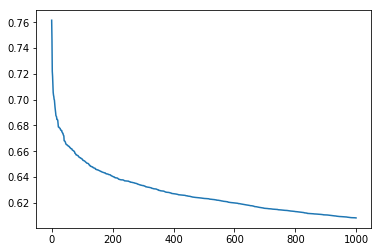

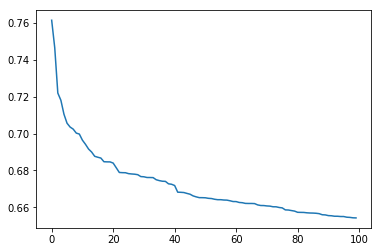

In [309]:
plt.plot(rankings[rankings_index])
plt.show()
plt.plot(rankings[rankings_index[:1000]])
plt.show()
plt.plot(rankings[rankings_index[:100]])
plt.show()

(array([1.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+01, 1.3000e+01, 2.9000e+01, 3.9000e+01, 4.6000e+01,
        5.2000e+01, 5.0000e+01, 8.3000e+01, 9.1000e+01, 1.3400e+02,
        1.6400e+02, 2.1200e+02, 1.9800e+02, 2.2100e+02, 2.4200e+02,
        2.8600e+02, 3.0000e+02, 3.0500e+02, 3.6600e+02, 4.2300e+02,
        4.5700e+02, 4.8400e+02, 4.8000e+02, 5.8600e+02, 1.5240e+03,
        6.4500e+02, 6.8700e+02, 7.7100e+02, 8.4800e+02, 8.9100e+02,
        1.0810e+03, 1.1000e+03, 1.2490e+03, 1.3390e+03, 1.5380e+03,
        1.6420e+03, 1.9120e+03, 2.0910e+03, 2.2790e+03, 2.5170e+03,
        2.7400e+03, 3.0940e+03, 3.2450e+03, 3.5920e+03, 4.0230e+03,
        4.3420e+03, 4.7670e+03, 5.1740e+03, 5.7120e+03, 6.4630e+03,
        6.4940e+03, 7.0500e+03, 7.8220e+03, 8.0600e+03, 8.5440e+03,
        8.7900e+03, 9.3240e+03, 9.8720e+03, 1.0241e+04, 1.0788e+04,
        1.0914e+04, 1.1303e+04, 1.1392e+04, 1.1410e+04, 1.1251e+04,
        1.1009e+04, 1.0726e+04, 1.0307e+04, 9.83

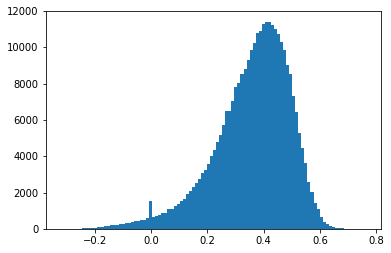

In [310]:
plt.hist(rankings[rankings_index], bins=100)

In [311]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [312]:
TOP_HITS_KMEANS = 10
TOP_HITS_KMEANS2 = np.argmax(rankings[rankings_index] < .65)
if TOP_HITS_KMEANS2 < 20:
    TOP_HITS_KMEANS2 = np.argmax(rankings[rankings_index] < .55)
TOP_HITS_KMEANS2 = max(TOP_HITS_KMEANS2, 20)
print("{}-{}, {}-{}".format(0, TOP_HITS_KMEANS, TOP_HITS_KMEANS, TOP_HITS_KMEANS2))
ranked_titles = titles[rankings_index].tolist()
top_ranked_em = n_weighted_embedding[rankings_index]
kmeans = KMeans(n_clusters=3, random_state=0).fit(top_ranked_em[:TOP_HITS_KMEANS])

0-10, 10-122


In [313]:
for i in range(min(20, TOP_HITS_KMEANS)):
    print(kmeans.labels_[i], "{:.4f}".format(rankings[rankings_index[i]]), titles[rankings_index[i]])

1 0.7615 TIL industry drug trials are 4 times more likely to give a positive result than independently sponsored trials
1 0.7466 TIL King Colomon of Hungary famously stated that "As for the matter of witches, there is no such thing, therefore no further investigations or trials are to be held" nearly 700 years before the Salem Witch Trials
2 0.7220 TIL that NEWS stands for "notable events, weather, and sports
0 0.7180 TIL A study has found that people who watch no news at all can answer questions about current events better than people who solely watch Fox News
2 0.7105 Today's /r/news are the next decades /r/TIL
0 0.7056 TIL a man set himself on fire on USA for first time in history and not a single main newspaper considered "news"
1 0.7035 TIL that during the Second World War, Nazi Germany performed very extensive medical experiments including extensive tests on children.... A lot of the experiments actually were used in developing modern medical techniques and many doctors got immun

In [314]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, top_ranked_em[:TOP_HITS_KMEANS])

In [315]:
for c, i in enumerate(closest):
    print(c, ranked_titles[i])

0 TIL there is man whose full-time hobby is giving man-on-the-street interviews so he'll be quoted in major publications. He’s so successful that the AP has banned their reporters from talking to him for stories.
1 TIL the FBI recently came forward to admit that their forensic examiners gave flawed testimony on hair sample testing for at least 257 trials over 20 years. (Another 2,200 cases are being reviewed and 32 were death penalty trials)
2 TIL that NEWS stands for "notable events, weather, and sports


In [316]:
kmeans2 = KMeans(n_clusters=7, random_state=0).fit(top_ranked_em[TOP_HITS_KMEANS:TOP_HITS_KMEANS2])
closest2, _ = pairwise_distances_argmin_min(kmeans2.cluster_centers_, top_ranked_em[TOP_HITS_KMEANS:TOP_HITS_KMEANS2])
for c, i in enumerate(closest2):
    print(c, ranked_titles[i + TOP_HITS_KMEANS])

0 TIL A new study published in the Journal of Medical Internet Research has claimed that a phone may be able to tell or predict depression in humans better than self-assessment.
1 TIL how the New York times was able to change its entire prepared front page in hours using pure investigative journalism, and what that means given our modern era of internet news aggregators
2 TIL there is a website called "darwinawards.com" which shows different stories where people committed suicide or died in a very unusual way.
3 Today's news headlines will in the future be TIL
4 TIL an Italian murder trial was stopped when the judge noticed two members of Court staff having sex.
5 TIL that a university student in Malta wrote a false article about Brexit as part of a research project about the phenomenon of fake news which later ends up being on a local newspaper believing that his article was legitimate
6 TIL 10 Greatest Historical events the world forgot about


# Doing more clusters and picking biggest ones

In [317]:
TOP_HITS_KMEANS = max(20,np.sum(scipy.stats.zscore(rankings[rankings_index]) > 3.5))
print(TOP_HITS_KMEANS)
ranked_titles = titles[rankings_index].tolist()
top_ranked_em = n_weighted_embedding[rankings_index]
kmeans = KMeans(n_clusters=20, random_state=0).fit(top_ranked_em[:TOP_HITS_KMEANS])

20


In [318]:
import collections
counter = collections.Counter(kmeans.labels_)
most_common = counter.most_common(10)
most_common = [i[0] for i in most_common]
closest2, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_[most_common], top_ranked_em[:TOP_HITS_KMEANS])
for c, i in enumerate(closest2):
    print(c, ranked_titles[i])

0 TIL industry drug trials are 4 times more likely to give a positive result than independently sponsored trials
1 TIL King Colomon of Hungary famously stated that "As for the matter of witches, there is no such thing, therefore no further investigations or trials are to be held" nearly 700 years before the Salem Witch Trials
2 TIL that NEWS stands for "notable events, weather, and sports
3 TIL A study has found that people who watch no news at all can answer questions about current events better than people who solely watch Fox News
4 Today's /r/news are the next decades /r/TIL
5 TIL a man set himself on fire on USA for first time in history and not a single main newspaper considered "news"
6 TIL that during the Second World War, Nazi Germany performed very extensive medical experiments including extensive tests on children.... A lot of the experiments actually were used in developing modern medical techniques and many doctors got immunity for revealing their study results.
7 TIL - Mc